In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)
warnings.simplefilter("ignore")

In [2]:
def get_class(fpath):
    klass=fpath.split('__')[1].split('.')[0]
    return klass
fpath = r'E:/Monis/coin_calculator/data/selected/train/19/004__50-Pence_united_kingdom_jpg.rf.63c1f0332369e517dbb596c865500a16.jpg'
klass=get_class(fpath)
print (klass)

50-Pence_united_kingdom_jpg


In [3]:
sdir=r'E:/Monis/coin_calculator/data/selected/'
classes=[]
datasets=os.listdir(sdir)
for d in datasets:
    dpath=os.path.join(sdir,d)    
    if os.path.isdir(dpath):
        print ('processing the ', d, ' dataset')
        filepaths = []
        labels=[]        
        classlist=os.listdir(dpath)
        for klass in classlist:            
            classpath=os.path.join(dpath, klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                fclass=fpath.split('__')[1].split('.')[0]                
                filepaths.append(fpath)
                labels.append(fclass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')        
        if d == 'train':
            train_df=pd.concat([Fseries, Lseries], axis=1)
        elif d == 'test':
            test_df=pd.concat([Fseries, Lseries], axis=1)
        else:
            valid_df= pd.concat([Fseries, Lseries], axis=1)
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=list(train_df['labels'].unique())
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

processing the  test  dataset
processing the  train  dataset
processing the  valid  dataset
train_df lenght:  705   test_df length:  123   valid_df length:  79
The number of classes in the dataset is:  32
            CLASS               IMAGE COUNT 
       1-Cent_australia             17      
    1-Penny_united_kingdom          21      
    2-Pence_united_kingdom          19      
    5-Pence_united_kingdom          13      
   10-Pence_united_kingdom          20      
   1-Rappen_switzerland_jpg         53      
   5-Rappen_switzerland_jpg         52      
  10-Rappen_switzerland_jpg         50      
 20-Pence_united_kingdom_jpg        38      
  20-Rappen_switzerland_jpg         28      
  1-2-Franc_switzerland_jpg         26      
   1-Franc_switzerland_jpg          13      
   2-Francs_switzerland_jpg         26      
   5-Francs_switzerland_jpg         26      
 50-Pence_united_kingdom_jpg        20      
    2-Cents_australia_jpg           17      
  1-Pound_united_kingdom_jpg  

In [4]:
def balance(df, n, working_dir, img_size):
    def augment(df,n, working_dir, img_size):
        aug_dir=os.path.join(working_dir, 'aug')
        os.mkdir(aug_dir)        
        for label in df['labels'].unique():    
            dir_path=os.path.join(aug_dir,label)    
            os.mkdir(dir_path)
        # create and store the augmented images  
        total=0
        gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                      height_shift_range=.2, zoom_range=.2)
        groups=df.groupby('labels') # group by class
        for label in df['labels'].unique():  # for every class               
            group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
            sample_count=len(group)   # determine how many samples there are in this class  
            if sample_count< n: # if the class has less than target number of images
                aug_img_count=0
                delta=n - sample_count  # number of augmented images to create
                target_dir=os.path.join(aug_dir, label)  # define where to write the images
                msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
                print(msg, '\r', end='') # prints over on the same line
                aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                                class_mode=None, batch_size=1, shuffle=False, 
                                                save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                                save_format='jpg')
                while aug_img_count<delta:
                    images=next(aug_gen)            
                    aug_img_count += len(images)
                total +=aug_img_count
        print('Total Augmented images created= ', total)
        # create aug_df and merge with train_df to create composite training set ndf
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)        
        df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
        return df 
    
    df=df.copy() 
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')    
    if 'aug' in os.listdir(working_dir):
        print(' Augmented images already exist. To delete these and create new images enter D, else enter U to use these images', flush=True)
        ans=input(' ')
        if ans == 'D' or ans == 'd':            
            shutil.rmtree(aug_dir) # start with an clean empty directory  
            augment(df,n, working_dir, img_size)
            return df
        else:
            
            return df
    else:
        augment(df,n, working_dir, img_size)
        return df
        
   
n=120 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(150,150) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

 Augmented images already exist. To delete these and create new images enter D, else enter U to use these images


In [5]:
batch_size=30 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 705 validated image filenames belonging to 32 classes.           for train generator 
Found 79 validated image filenames belonging to 32 classes.            for valid generator 
Found 123 validated image filenames belonging to 32 classes.           for test generator 
test batch size:  41   test steps:  3  number of classes :  32


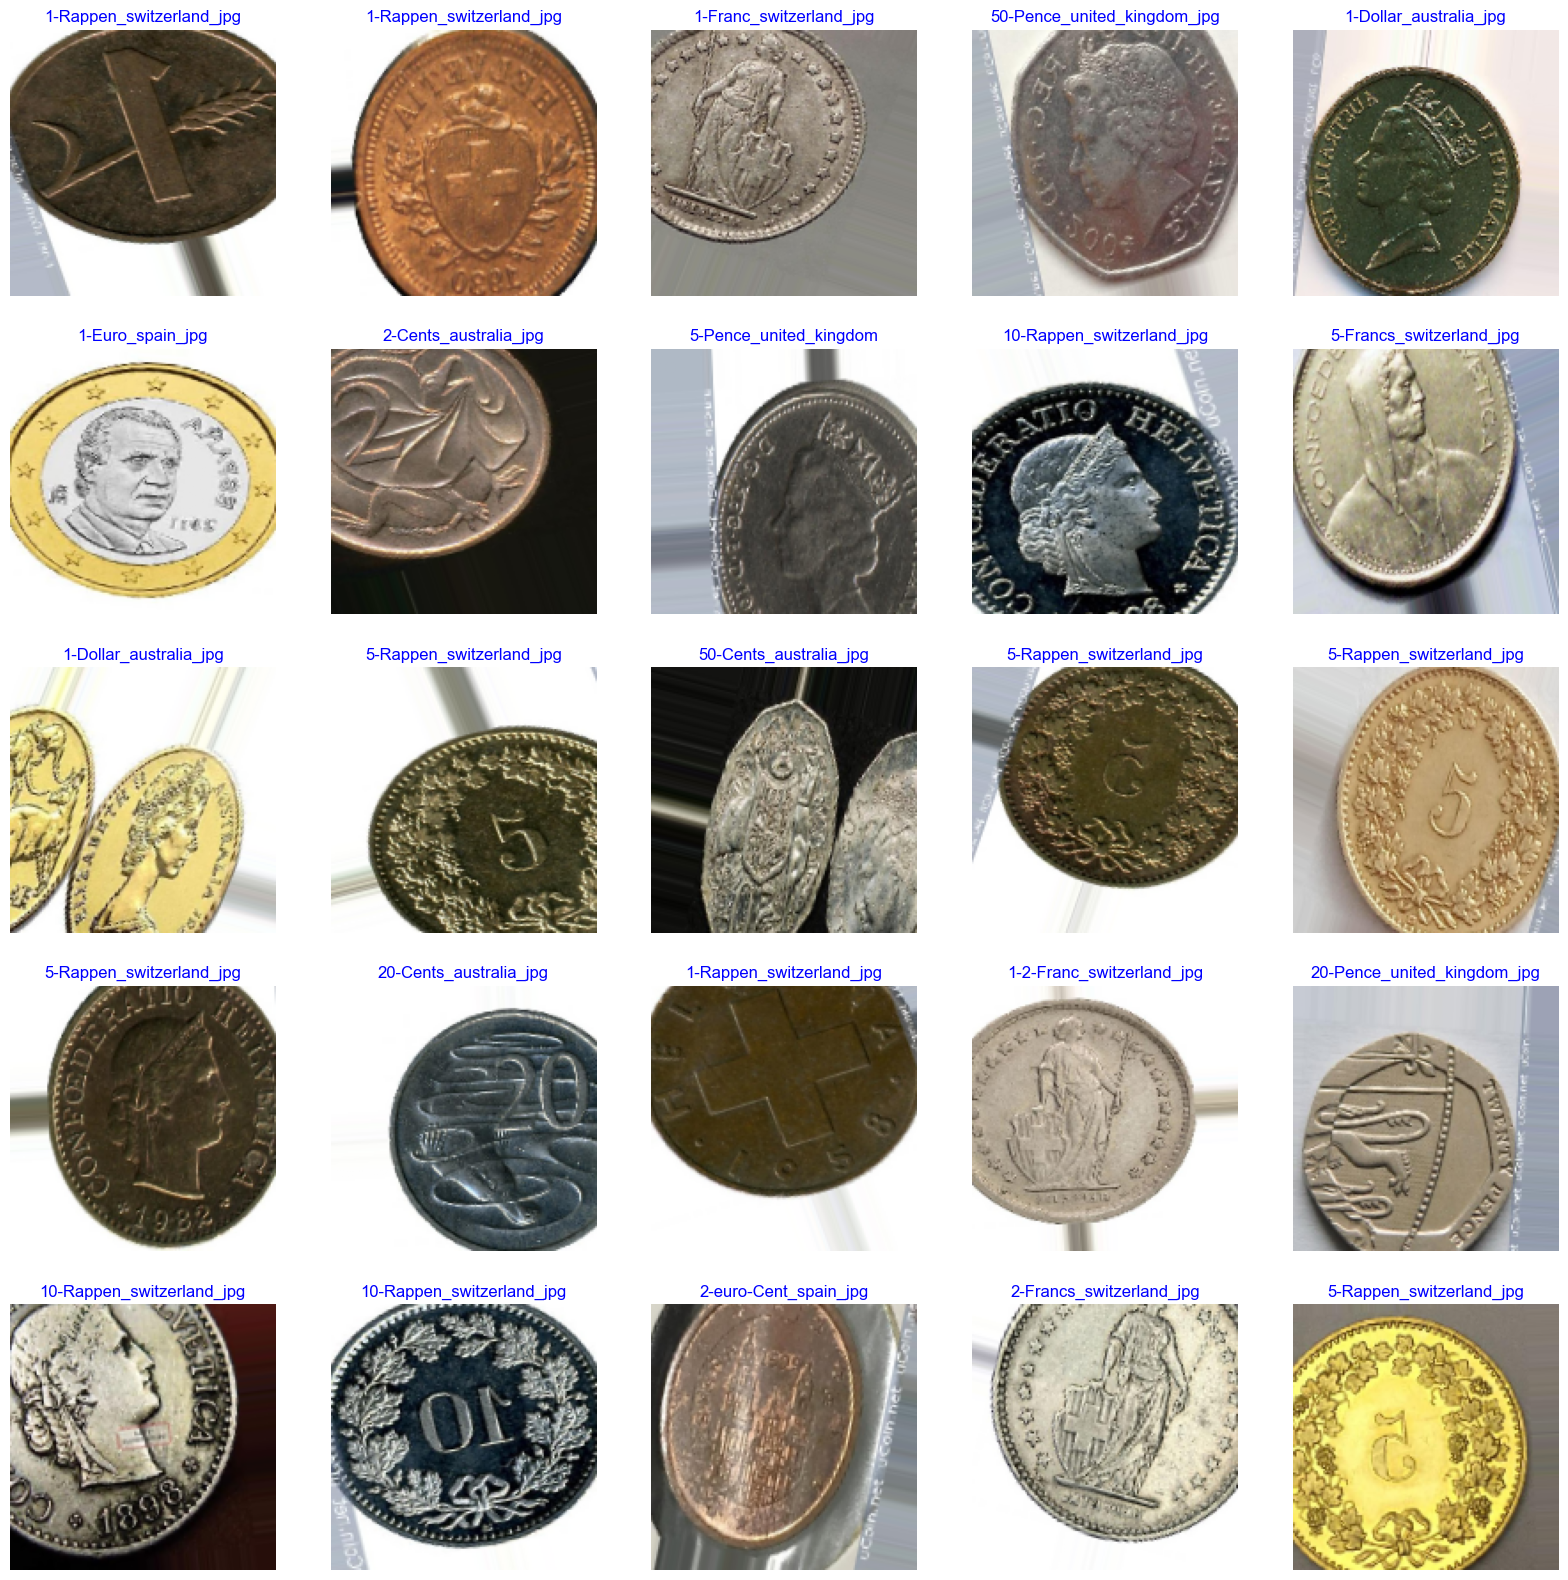

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [7]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [8]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [9]:
epochs=40
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [10]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
24/24 [==============================] - 111s 4s/step - loss: 11.1319 - accuracy: 0.1844 - val_loss: 11.3098 - val_accuracy: 0.2785 - lr: 0.0010
Epoch 2/40
24/24 [==============================] - 106s 4s/step - loss: 9.4130 - accuracy: 0.4255 - val_loss: 9.9822 - val_accuracy: 0.3797 - lr: 0.0010
Epoch 3/40
24/24 [==============================] - 97s 4s/step - loss: 8.3922 - accuracy: 0.6156 - val_loss: 9.1551 - val_accuracy: 0.3671 - lr: 0.0010
Epoch 4/40
24/24 [==============================] - 95s 4s/step - loss: 7.6903 - accuracy: 0.7078 - val_loss: 8.7633 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 5/40
24/24 [==============================] - ETA: 0s - loss: 7.2449 - accuracy: 0.7631
 Enter H to end training or  an integer for the number of additional epochs to run then ask again
you entered  10  Training will 

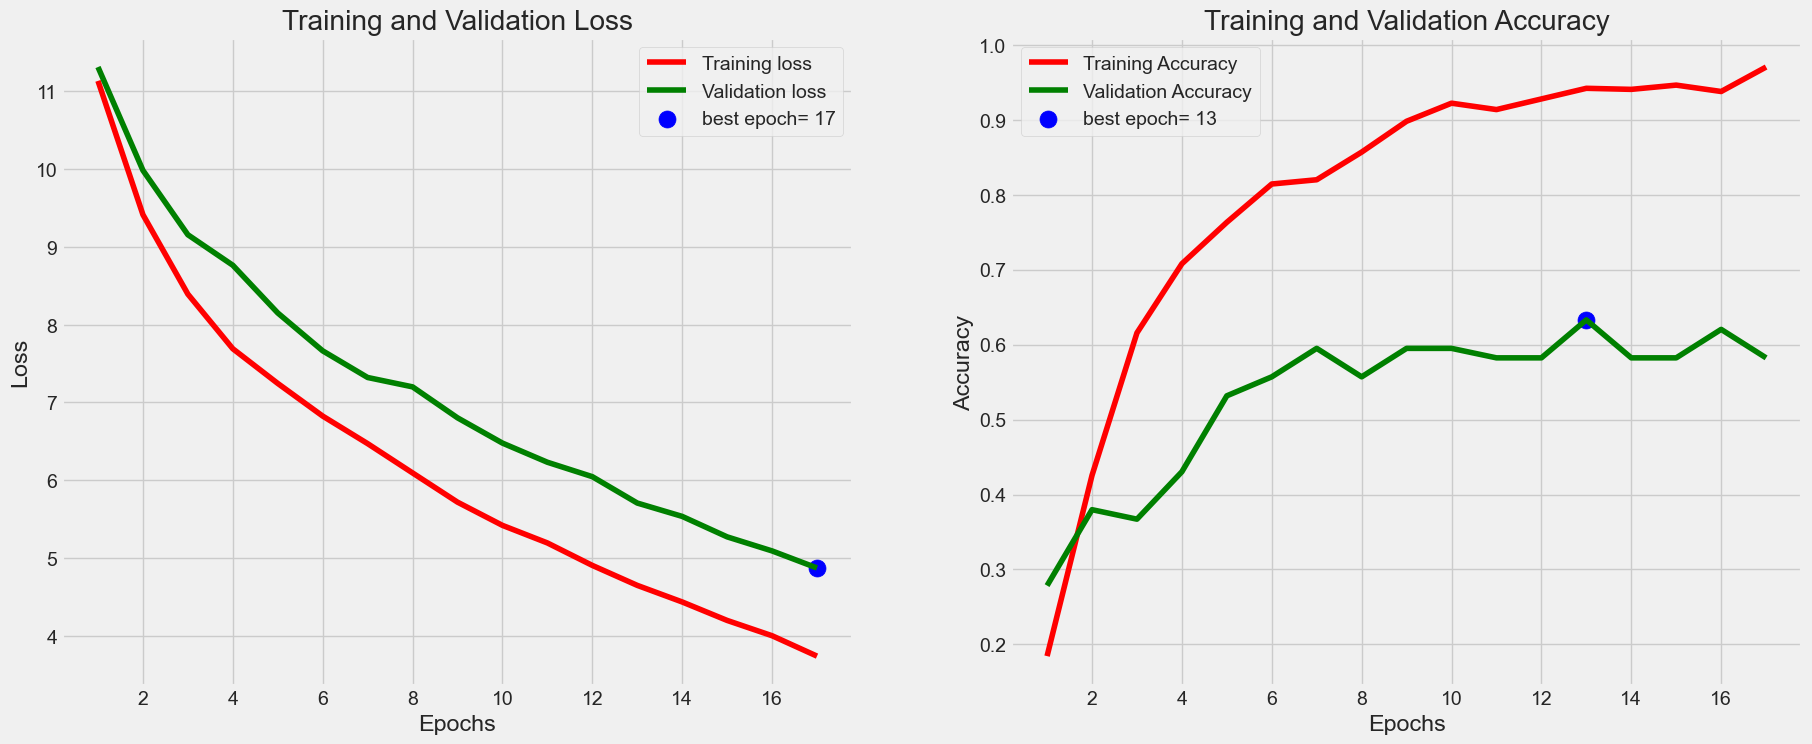

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [12]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(16, 10))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

3/3 [==============================] - 6s 1s/step
there were 31 in 123 tests for an accuracy of  74.80
Classification Report:
----------------------
                              precision    recall  f1-score   support

  1-2-Franc_switzerland_jpg     0.0000    0.0000    0.0000         4
           1-Cent_australia     1.0000    1.0000    1.0000         4
     1-Dollar_australia_jpg     1.0000    0.5000    0.6667         4
           1-Euro_spain_jpg     1.0000    0.5000    0.6667         2
    1-Franc_switzerland_jpg     1.0000    0.2500    0.4000         4
     1-Penny_united_kingdom     1.0000    1.0000    1.0000         4
 1-Pound_united_kingdom_jpg     1.0000    0.6667    0.8000         3
   1-Rappen_switzerland_jpg     1.0000    1.0000    1.0000         4
      1-euro-Cent_spain_jpg     0.5000    0.5000    0.5000         4
     10-Cents_australia_jpg     1.0000    0.5000    0.6667         4
    10-Pence_united_kingdom     0.8000    1.0000    0.8889         4
  10-Rappen_switzerla

In [14]:
subject='coins' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

model was saved as  ./coins_74.79.h5


In [15]:
model = tf.keras.models.load_model('coins_74.79.h5')

In [18]:
def preprocess_image(image):
    # Preprocess the image as per your training pipeline
    # For example, resize the image to match the input size of your model and normalize pixel values
    # You can use OpenCV (cv2) or any other library for image preprocessing

    # Example preprocessing steps:
    image = cv2.resize(image, (150, 150))  # Resize the image to the desired input size
    image = image.astype(np.float32) / 255.0  # Normalize pixel values between 0 and 1
    image = np.expand_dims(image, axis=0)  # Add a batch dimension

    return image

def predict_single_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    preprocessed_image = preprocess_image(image)

    # Make predictions on the preprocessed image
    predictions = model.predict(preprocessed_image)

    # Post-process the predictions as per your model's output
    # For example, decode the predicted classes or retrieve the predicted probabilities

    # Example post-processing steps:
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class
    confidence = np.max(predictions, axis=1)[0]  # Get the confidence or probability of the predicted class

    return predicted_class, confidence

In [21]:
# Path to the single image you want to make predictions on
image_path = 'C:/Users/saad9/Downloads/download.jpeg'

# Call the predict_single_image function to get predictions
predicted_class, confidence = predict_single_image(image_path)

# Print the predicted class and confidence
print('Predicted Class:', predicted_class)
print('Confidence:', confidence)

1/1 [==============================] - 0s 158ms/step
Predicted Class: 7
Confidence: 0.0938037
